<font size="1">Copyright 2021, by the California Institute of Technology. ALL RIGHTS RESERVED. United States Government sponsorship acknowledged. Any commercial use must be negotiated with the Office of Technology Transfer at the California Institute of Technology.</font>
    
<font size="1">This software may be subject to U.S. export control laws and regulations. By accepting this document, the user agrees to comply with all applicable U.S. export laws and regulations. User has the responsibility to obtain export licenses, or other export authority as may be required, before exporting such information to foreign countries or providing access to foreign persons.<font>

# Datasets
This notebook will use the Pele API to query available datasets and download one from S3 based on the metadata returned by the query.

## Setup

This notebook assumes you've already gone through the first notebook and registered a user and password, as well sa populated your .netrc file. Let's go ahead and set things up so that we can utilize the Pele client library to query our datasets.

In [1]:
import os
import requests, json, getpass
from requests.auth import HTTPBasicAuth
import urllib3
from urllib.parse import urlparse

urllib3.disable_warnings()

# this block makes sure the directory set-up/change is only done once and relative to the notebook's directory
try:
    start_dir
except NameError:
    start_dir = os.getcwd()
    !mkdir -p ./notebook_output/L1_L_RSLC-Analysis
    os.chdir('notebook_output/L1_L_RSLC-Analysis')
    
# set the base url to interact with the goddess, Pele
#base_url = input("Enter Pele REST API base url (e.g. https://<mozart_ip>/pele/api/v0.1) then press <Enter>: ")
base_url = "https://100.64.122.181/pele/api/v0.1"
print("Using base url {}.".format(base_url))

Using base url https://100.104.10.147/pele/api/v0.1.


Let's validate that we can interact with Pele:

In [2]:
from pele_client.client import PeleRequests

# instantiate PeleRequests object
pr = PeleRequests(base_url, verify=False, auth=False)

# now use like requests module (`request()`, `get()`, `head()`, `post()`, `put()`, `delete()`, `patch()`)
r = pr.get(base_url + '/test/echo', params={'echo_str': 'hello world'})

# expect 200
print("status code: {}".format(r.status_code))
print(json.dumps(r.json(), indent=2))
assert r.status_code == 200

status code: 200
{
  "success": true,
  "message": "hello world"
}


## Querying

Let's see what datasets we have:

In [3]:
# get datasets
r = pr.get(base_url + '/pele/datasets')

# expect 200
print("status code: {}".format(r.status_code))
res = r.json()
print(json.dumps(res, indent=2))
assert r.status_code == 200
assert "L1_L_RSLC" in res['datasets']

status code: 200
{
  "success": true,
  "message": null,
  "datasets": [
    "L0B_L_RRSD",
    "STUF",
    "triaged_job",
    "COP",
    "CHIRP_PARAM",
    "L1_L_RSLC",
    "NET",
    "POE",
    "PTA",
    "RADAR_CFG"
  ],
  "total": 15,
  "count": 10,
  "page_size": 10,
  "offset": 0
}


Let's look at the `L1_L_RSLC` dataset type and query for dataset ids:

In [4]:
# query for all dataset IDs of the `L1_L_RSLC` dataset
r = pr.get(base_url + '/pele/dataset/L1_L_RSLC/dataset_ids')

# expect 200
print("status code: {}".format(r.status_code))
res = r.json()
print(json.dumps(res, indent=2))
assert r.status_code == 200

status code: 200
{
  "success": true,
  "message": null,
  "dataset_ids": [
    "NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001"
  ],
  "total": 1,
  "count": 1,
  "page_size": 10,
  "offset": 0
}


We have a number of `L1_L_RSLC` granules but the API returns only 10. Let's collect all of them by iterating over the paged results 10 at a time:

In [5]:
rslc_ids = res['dataset_ids']
while len(rslc_ids) != res['total']:
    r = pr.get(base_url + '/pele/dataset/L1_L_RSLC/dataset_ids', params={'offset': res['offset']+res['page_size']})
    res = r.json()
    rslc_ids.extend(res['dataset_ids'])
    
# expect 200
print("All L1_L_RSLC ids: {}".format(rslc_ids))
print(len(rslc_ids))

All L1_L_RSLC ids: ['NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001']
1


Let's take a look at the metadata for one of those granules:

In [6]:
# query for metadata of the first `L1_L_RSLC` dataset
r = pr.get(base_url + '/pele/dataset/{}'.format(rslc_ids[0]))

# expect 200
print("status code: {}".format(r.status_code))
res = r.json()
print(json.dumps(res, indent=2))

# get hdf5 file name
h5_file = res['result']['metadata']['FileName']
print(h5_file)

status code: 200
{
  "success": true,
  "message": null,
  "result": {
    "browse_urls": [
      "http://nisar-dev-rs-fwd-gmanipon.s3-website-us-west-2.amazonaws.com/browse/L1_L_RSLC/2011/02/02/NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001",
      "s3://s3-us-west-2.amazonaws.com:80/nisar-dev-rs-fwd-gmanipon/browse/L1_L_RSLC/2011/02/02/NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001"
    ],
    "urls": [
      "http://nisar-dev-rs-fwd-gmanipon.s3-website-us-west-2.amazonaws.com/products/L1_L_RSLC/2011/02/02/NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001",
      "s3://s3-us-west-2.amazonaws.com:80/nisar-dev-rs-fwd-gmanipon/products/L1_L_RSLC/2011/02/02/NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001"
    ],
    "version": "d00001",
    "objectid": "NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001"

You essentially get the granule's entire JSON metadata. Let's pull the URLs so that we can download the granule:

In [7]:
# pull the urls
urls = res['result']['urls']
print("urls: {}".format(urls))

urls: ['http://nisar-dev-rs-fwd-gmanipon.s3-website-us-west-2.amazonaws.com/products/L1_L_RSLC/2011/02/02/NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001', 's3://s3-us-west-2.amazonaws.com:80/nisar-dev-rs-fwd-gmanipon/products/L1_L_RSLC/2011/02/02/NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001']


We want to utilize the S3 URL so that we can utilize the S3 API for faster downloads:

In [8]:
s3_url = None
for i in urls:
    if i.startswith('s3://'): s3_url = i
assert s3_url is not None

### Now let's download that dataset from S3, but before we can we need to populate the .aws/credentials file with the access key information. 

Use a terminal to execute aws-login:

    aws-login -pub -p default -r us-west-2
    

In [9]:
import os

# get the S3 url format that awscli requires
url = 's3://{}'.format(urlparse(s3_url).path[1:])
print(url)
local_dir = os.path.basename(url)
print (local_dir)
!aws s3 sync {url} {local_dir}

s3://nisar-dev-rs-fwd-gmanipon/products/L1_L_RSLC/2011/02/02/NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001
NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001
download: s3://nisar-dev-rs-fwd-gmanipon/products/L1_L_RSLC/2011/02/02/NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001/NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001.h5.md5 to NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001/NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001.h5.md5
download: s3://nisar-dev-rs-fwd-gmanipon/products/L1_L_RSLC/2011/02/02/NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001/NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001.dataset.json to NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D0000

In [10]:
!pwd
!ls -al {local_dir}

/home/jovyan/dev/nisar-on-demand-use-cases/notebook_output/L1_L_RSLC-Analysis
total 715748
drwxr-sr-x 2 jovyan users      4096 Jul  1 17:55 .
drwxr-sr-x 3 jovyan users      4096 Jul  1 17:55 ..
-rw-r--r-- 1 jovyan users     10958 Jul  1 15:10 NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001.context.json
-rw-r--r-- 1 jovyan users      3397 Jul  1 15:10 NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001.dataset.json
-rw-r--r-- 1 jovyan users 729218733 Jul  1 15:10 NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001.h5
-rw-r--r-- 1 jovyan users   3652112 Jul  1 15:10 NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001.h5.log
-rw-r--r-- 1 jovyan users        32 Jul  1 15:10 NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001.h5.md5
-rw-r--r-- 1 jovyan users      4986 Jul  1 15:10 NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_

In [11]:
!h5ls -r $local_dir/$h5_file

/                        Group
/science                 Group
/science/LSAR            Group
/science/LSAR/RSLC       Group
/science/LSAR/RSLC/metadata Group
/science/LSAR/RSLC/metadata/attitude Group
/science/LSAR/RSLC/metadata/attitude/angularVelocity Dataset {22, 3}
/science/LSAR/RSLC/metadata/attitude/attitudeType Dataset {SCALAR}
/science/LSAR/RSLC/metadata/attitude/eulerAngles Dataset {22, 3}
/science/LSAR/RSLC/metadata/attitude/quaternions Dataset {22, 4}
/science/LSAR/RSLC/metadata/attitude/time Dataset {22}
/science/LSAR/RSLC/metadata/geolocationGrid Group
/science/LSAR/RSLC/metadata/geolocationGrid/alongTrackUnitVectorX Dataset {20, 123, 98}
/science/LSAR/RSLC/metadata/geolocationGrid/alongTrackUnitVectorY Dataset {20, 123, 98}
/science/LSAR/RSLC/metadata/geolocationGrid/coordinateX Dataset {20, 123, 98}
/science/LSAR/RSLC/metadata/geolocationGrid/coordinateY Dataset {20, 123, 98}
/science/LSAR/RSLC/metadata/geolocationGrid/elevationAngle Dataset {20, 123, 98}
/science/LSAR/R

In [12]:
!gdalinfo HDF5:"$local_dir/$h5_file"://science/LSAR/RSLC/swaths/frequencyA/HH

Driver: HDF5Image/HDF5 Dataset
Files: NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001/NISAR_L1_PR_RSLC_040_128_D_166_2800_HH_20110202T062952_20110202T062959_D00001_P_F_001.h5
Size is 10344, 17241
Metadata:
  contact=nisarops@jpl.nasa.gov
  Conventions=CF-1.8
  institution=NASA JPL
  mission_name=NISAR
  reference_document=TBD
  title=NISAR L1 RSLC Product
Corner Coordinates:
Upper Left  (    0.0,    0.0)
Lower Left  (    0.0,17241.0)
Upper Right (10344.0,    0.0)
Lower Right (10344.0,17241.0)
Center      ( 5172.0, 8620.5)
Band 1 Block=10344x1 Type=CFloat32, ColorInterp=Undefined
  Metadata:
    science_LSAR_RSLC_swaths_frequencyA_HH_description=Focused SLC image (HH)
    science_LSAR_RSLC_swaths_frequencyA_HH_units=DN


### Next let's translate the SLC to the ENVI format to be read in by GDAL and visualized by 

Use a terminal to execute aws-login:

    aws-login -pub -p default -r us-west-2

In [13]:
!gdal_translate -of ENVI HDF5:"$local_dir/$h5_file"://science/LSAR/RSLC/swaths/frequencyA/HH HH.slc

Input file size is 10344, 17241
0...10...20...30...40...50...60...70...80...90...100 - done.


In [14]:
!gdalinfo HH.slc

Driver: ENVI/ENVI .hdr Labelled
Files: HH.slc
       HH.slc.aux.xml
       HH.hdr
Size is 10344, 17241
Metadata:
  contact=nisarops@jpl.nasa.gov
  Conventions=CF-1.8
  institution=NASA JPL
  mission_name=NISAR
  reference_document=TBD
  title=NISAR L1 RSLC Product
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (    0.0,    0.0)
Lower Left  (    0.0,17241.0)
Upper Right (10344.0,    0.0)
Lower Right (10344.0,17241.0)
Center      ( 5172.0, 8620.5)
Band 1 Block=10344x1 Type=CFloat32, ColorInterp=Undefined
  Metadata:
    science_LSAR_RSLC_swaths_frequencyA_HH_description=Focused SLC image (HH)
    science_LSAR_RSLC_swaths_frequencyA_HH_units=DN


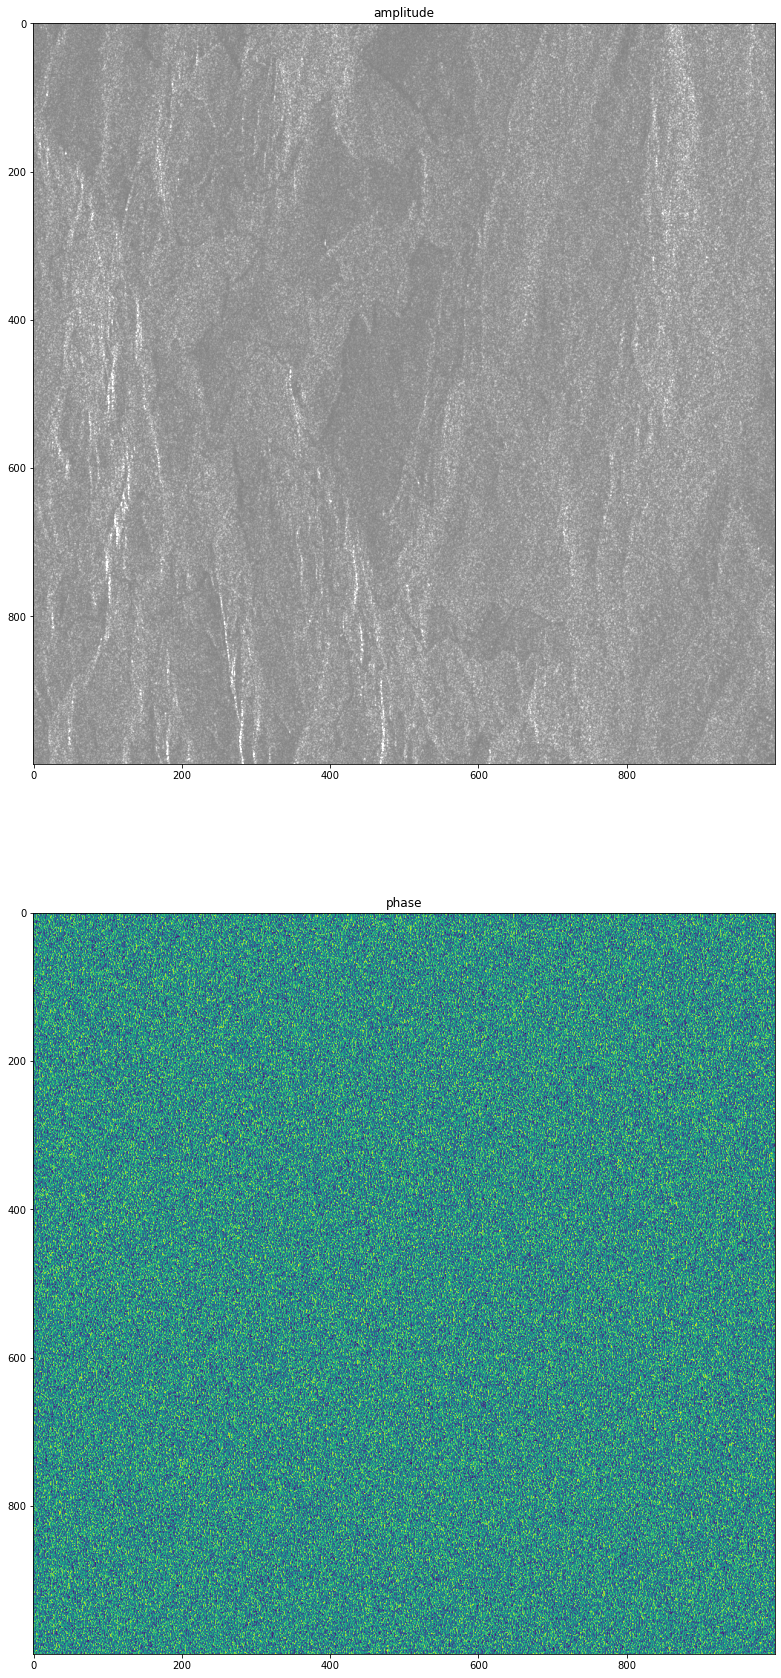

In [25]:
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt

ds = gdal.Open("HH.slc", gdal.GA_ReadOnly)

# extract a subset of the SLC to display
x0 = 0
y0 = 10
x_offset = 1000
y_offset = 1000
#x_offset = 500
#y_offset = 500

#slc = ds.GetRasterBand(1).ReadAsArray()           
slc = ds.GetRasterBand(1).ReadAsArray(x0, y0, x_offset, y_offset)
#print(slc)
ds = None

fig = plt.figure(figsize=(20, 30))
#fig = plt.figure(figsize=(14, 12))

# display amplitude of the slc
ax = fig.add_subplot(2,1,1)
ax.imshow(np.abs(slc), vmin = -2, vmax=2, cmap='gray')
ax.set_title("amplitude")

#display phase of the slc
ax = fig.add_subplot(2,1,2)
ax.imshow(np.angle(slc))
ax.set_title("phase")

plt.show()

slc = None

<font size="1">This notebook is compatible with NISAR Jupyter Server Stack v1.4 and above</font>